# Building a time-series prediction model for NYC bike share 

In this lab we will use hourly usage volumes of the New York City bike share system as a time series to predict.

## Learning Objectives
1. Choose 
2. Evaluate 
3. Improve 
4. Create 

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](../labs/citibike_trips_hourly.ipynb) -- try to complete that notebook first before reviewing this solution notebook. 


## Import python libaries 

In [46]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: cloud-learning-reports


In [ ]:
!pip install pandas-profiling[notebook,html]
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]

In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os, json, math, shutil
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import logging
# SET TF ERROR LOG VERBOSITY
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import pandas as pd
from pandas_profiling import ProfileReport
import tensorflow as tf

PROJECT = "cloud-learning-reports" # REPLACE WITH YOUR PROJECT NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["BUCKET"] = PROJECT # DEFAULT BUCKET WILL BE PROJECT ID

if PROJECT == "your-gcp-project-here":
  print("Don't forget to update your PROJECT name! Currently:", PROJECT)

print(tf.__version__)

2.1.0


## Explore and import our Citibike trips dataset
Launched in 2013, [Citibike](https://www.citibikenyc.com/) provides bike rentals in New York City. They have partnered with Google to make their bike share trips available in BigQuery for analysis. 

The `bigquery-public-data.new_york_citibike.citibike_trips` dataset is where we will be gathering our data for our bike demand time series prediction model. 

### Explore the data in BigQuery

How many trips by year are available for analysis?

In [14]:
%%bigquery
SELECT
    EXTRACT(year from starttime) AS year,
    COUNT(*) AS total_trips
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE starttime IS NOT NULL
GROUP BY year
ORDER BY year DESC

,year,total_trips
0,2018,5671033
1,2017,14118669
2,2016,10262649
3,2015,9937969
4,2014,8081216
5,2013,5037185


What columns are available for analysis?

In [15]:
%%bigquery
SELECT *
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
LIMIT 5;

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,437,2018-03-29 18:48:21.032,2018-03-29 18:55:38.808,3101,N 12 St & Bedford Ave,40.720798,-73.954847,3082,Hope St & Union Ave,40.711674,-73.951413,19860,Subscriber,1996,female,
1,987,2016-09-13 07:53:30.000,2016-09-13 08:09:58.000,515,W 43 St & 10 Ave,40.760094,-73.994618,522,E 51 St & Lexington Ave,40.757148,-73.972078,19412,Subscriber,1947,male,
2,1827,2015-05-07 14:14:57.000,2015-05-07 14:45:24.000,417,Barclay St & Church St,40.712912,-74.010202,322,Clinton St & Tillary St,40.696192,-73.991218,16406,Subscriber,1944,female,
3,1103,2017-12-27 07:53:04.000,2017-12-27 08:11:27.000,3260,Mercer St & Bleecker St,40.727064,-73.996621,536,1 Ave & E 30 St,40.741444,-73.975361,32994,Subscriber,1947,male,
4,445,2016-07-10 21:37:21.000,2016-07-10 21:44:47.000,3176,W 64 St & West End Ave,40.774528,-73.987538,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,25471,Subscriber,1996,male,


### Sample the data
Next we'll explore ~33 million trips, grouped by hour, from 2013 to 2016. Let's write and execute the query.

In [12]:
%%bigquery
SELECT
    datetime_trunc(starttime, hour) AS starttime,
    COUNT(*) AS trips
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE 
    starttime is not null 
    AND starttime < '2016-09-27'
GROUP BY starttime 
ORDER BY starttime

,starttime,trips
0,2013-07-01 00:00:00,229
1,2013-07-01 01:00:00,106
2,2013-07-01 02:00:00,74
3,2013-07-01 03:00:00,41
4,2013-07-01 04:00:00,37
...,...,...
28296,2016-09-26 19:00:00,4204
28297,2016-09-26 20:00:00,2948
28298,2016-09-26 21:00:00,1323
28299,2016-09-26 22:00:00,1036


### Load the query results into a Pandas dataframe
- We'll use the [BigQuery API](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas) to download the results of our query into a dataframe
- We also convert the string containing a timestamp to a `datetime` timestamp, and set is as the dataframe index.

In [55]:
client = bigquery.Client()
sql = """
SELECT
    datetime_trunc(starttime, hour) AS starttime,
    COUNT(*) AS trips
FROM `bigquery-public-data.new_york_citibike.citibike_trips` 
WHERE 
    starttime is not null 
    AND starttime < '2016-09-27'
GROUP BY starttime 
ORDER BY starttime
"""

# Run a Standard SQL query using the environment's default project
df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = PROJECT # Set earlier in the notebook
df = client.query(sql, project=project_id).to_dataframe()

df["starttime"] = pd.to_datetime(df["starttime"])
df = df.set_index('starttime')
print(df.shape)
df.head()

(28301, 1)


,trips
starttime,
2013-07-01 00:00:00,229
2013-07-01 01:00:00,106
2013-07-01 02:00:00,74
2013-07-01 03:00:00,41
2013-07-01 04:00:00,37


As you can see from the shape of the data frame we have 28,301 "hour buckets" of data. But is every hour of the day accounted for?

Let's take the first and last datetime and count the number of hours between those endpoints:

In [57]:
pd.date_range(min(df.index), max(df.index), freq="1h").shape

(28416,)

Looks like we're missing a few hour buckets -- we'll need to fill those in before we can do proper time-series forecasting.

### Create a continuous timeframe
Our dataset contains fewer rows than the the number of hours between its earliest and latest hour -- this is because there are hours where no bike trips were initiated. In order to create a proper time series, we need to insert these missing hours as new rows.
- Using Pandas, we will reindex the dataframe and fill in missing values at the 1 hour frequency with "0"

In [58]:
idx = pd.date_range(min(df.index), max(df.index), freq="1h") # lab todo
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, fill_value = 0)
df.index.name = "starttime"

print(df.shape)
df.head()

(28416, 1)


,trips
starttime,
2013-07-01 00:00:00,229
2013-07-01 01:00:00,106
2013-07-01 02:00:00,74
2013-07-01 03:00:00,41
2013-07-01 04:00:00,37


## Create a training dataset from hourly data

In the following we will closely follow the [Time series forecasting tutorial on tensorflow.org](https://www.tensorflow.org/tutorials/structured_data/time_series). 

The following function generates the training dataset given the desired past history size and future target size for a single variable (univariate) dataset. Here our only variable is number of trips per each hour bucket.

In [61]:
# from https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

We will set the number of rows going into the training set, the rest will be our validation dataset.

In [62]:
TRAIN_SPLIT = 20000
tf.random.set_seed(13)

Let's visualize our dataset:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f12bcdb6d90>],
      dtype=object)

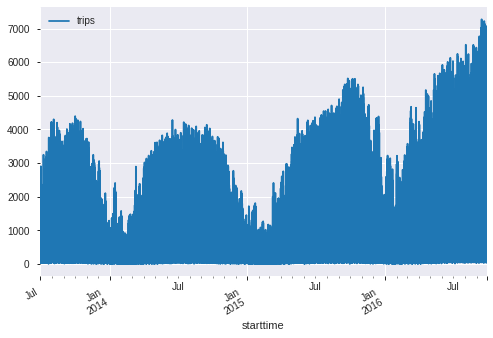

In [63]:
df.plot(subplots = True)

You can see the effect that seasonality has on bike rides in NYC. Each summer from 2014 - 2016 also shows increasing numbers of trips.

## Normalizing the dataset

We will normalize our data, however, we should only calculate the statistics on our training set to avoid data leakage.

In [64]:
uni_data = df.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.

In [69]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's standardize the data

In [70]:
uni_data = (uni_data-uni_train_mean)/uni_train_std


### TODO #X: Set the correct history widnow

Let's now create the data for the univariate model. For part 1, the model will be given the last two week's of "trips per hour" observations, and needs to learn to predict the number of trips at the next time step.

- Set below the desired `past_history` lookback window to be used to be two weeks (units will be hours)
- Set the length of the `future_target` prediction window to be a single day (units will be hours)

Note: Later you can experiment with changing these values to possibly improve predictions

In [67]:
past_history = 2*24*7 # two weeks, lab todo
future_target = 24-1 # one day #JONESEVAN - HOW WILL THEY KNOW ITS NOT 24 HOURS?

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

This is what the univariate_data function returns for our "trips per hour" historical training data and also the window to predict for.

In [68]:
print ('Single window of past history')
print (x_train_uni[0].shape)
print ('\n Target value to predict')
print (y_train_uni[0].shape)

Single window of past history
(336, 1)

 Target value to predict
(23, 1)


For this initial experiment we will train the model on 336 hours ago (two weeks) and predict the trip counts for each of the next 23 hours.

### Plotting the history and future data on a time-series
- Before we train a model using TensorFlow, let's plot what a perfect model would predict

In [74]:
def create_time_steps(length):
  return list(range(-length, 0))

In [75]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

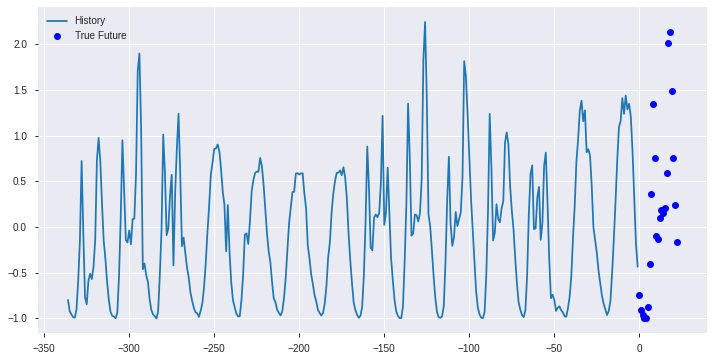

In [76]:
multi_step_plot(x_train_uni[0], y_train_uni[0], np.array([0]))

## Part 2: Create a LSTM time-series model in TensorFlow
- Now we'll create an official `tf.data.Dataset` from our training data
- We'll then use tf.data to shuffle, batch, and cache the dataset

In [81]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### TODO #X: Create the keras model architecture

Specify the initial hyperparameters for our LSTM model
- It should have 8 units and an initial `input_shape` of `x_train_uni.shape[-2:]),
- A second dense layer for `future_target`
- Use the "adam" optimizer and the "mae" loss function

Here we create our LSTM model, do change its architecture (number of units, a second LSTM layer, different optimizer) to explore models with different predictive performance.

In [82]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, # lab todo parameters
                         input_shape=x_train_uni.shape[-2:]), 
    tf.keras.layers.Dense(future_target)
])

lstm_model.compile(optimizer="adam", loss='mae') # lab todo


In [83]:
for x, y in val_univariate.take(1):
    print(lstm_model.predict(x).shape)

(256, 23)


### Check for smoothness in gradient descent before running all training

Below we train our model, do adjust the evaluation interval and epochs to arrive at a smoothly decreasing evaluation loss.

Here we will evaluate every 50 and limit the epochs to just 10. Watch the `loss` and ensure it decreases smoothly.

Note: This will take 2-3 minutes to complete.

In [84]:
EVALUATION_INTERVAL = 50
EPOCHS = 10

lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/10
50/50 [==============================] - 11s 228ms/step - loss: 0.7694 - val_loss: 0.9865
Epoch 2/10
50/50 [==============================] - 10s 192ms/step - loss: 0.7380 - val_loss: 0.9433
Epoch 3/10
50/50 [==============================] - 10s 192ms/step - loss: 0.6864 - val_loss: 0.8816
Epoch 4/10
50/50 [==============================] - 10s 193ms/step - loss: 0.5804 - val_loss: 0.8049
Epoch 5/10
50/50 [==============================] - 10s 193ms/step - loss: 0.5316 - val_loss: 0.7319
Epoch 6/10
50/50 [==============================] - 10s 196ms/step - loss: 0.4773 - val_loss: 0.6868
Epoch 7/10
50/50 [==============================] - 10s 192ms/step - loss: 0.4263 - val_loss: 0.6610
Epoch 8/10
50/50 [==============================] - 10s 195ms/step - loss: 0.4370 - val_loss: 0.6382
Epoch 9/10
50/50 [==============================] - 10s 196ms/step - loss: 0.4102 - val_loss: 0.6255
Epoch 10/10
50/50 [==============================

### Side note: loss vs val_loss
`val_loss` is the value of cost function for your cross-validation data and `loss` is the value of cost function for your training data. On validation data, neurons using drop out do not drop random neurons. The reason is that during training we use drop out in order to add some noise for avoiding over-fitting. During calculating cross-validation, we are in the recall phase and not in the training phase. We use all the capabilities of the network.

### Plot some sample predictions:

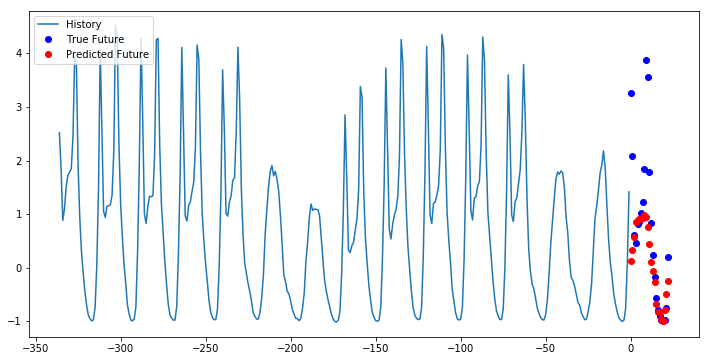

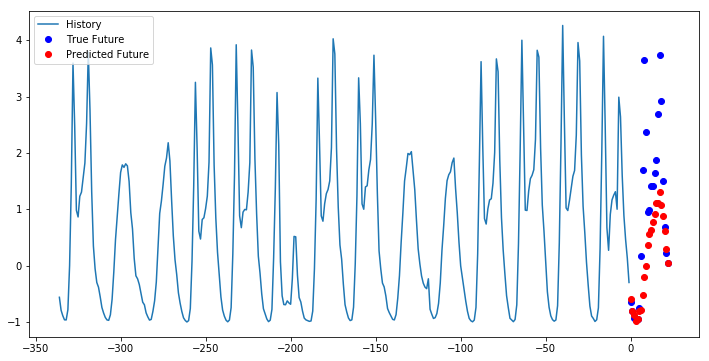

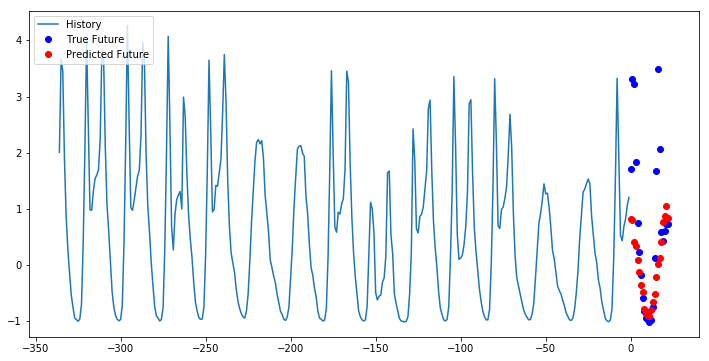

In [20]:
for x, y in val_univariate.take(3):
  plot = multi_step_plot(x[0].numpy(),
                    y[0].numpy(),
                    lstm_model.predict(x)[0])

## Evaluate the model
- JONESEVAN - Is there an easy way to do model evaluations for time series as a metric?

## Improve the model
- Adjust the LSTM hyperparamters and see if you can get better model performance
- Adjust the training window and prediction window
- Adjust the overall `WHERE` clause filter on the initial dataset pull from BigQuery to see if more data helps

## References
- 